# Improving ResNet

In this notebook, I implement ResNet50 with Keras and finetune the model on the MNIST dataset. Typically MNIST is a benchmark for computer vision algorithms and contains images of thousands of handwritten digits. And in particular, I chose this challenge because of its balanced data set, reliable labels, but mainly because I wanted to focus on highlighting the architecture of ResNet and finetuning. Because MNIST is so well used, I have a benchmark against which to compare my model performance.

I reconstruct ResNet from scratch with a TensorFlow 2.0 Keras framework, modify it to use more advanced neuron activation function and achieve very solid results (98.5% Accuracy, but you'll see my other important metrics (AUC, Precision, Recall) are all just as great!)

I hope that my dive into the architecture of ResNet 50 can showcase the backbone of this state of the art neural network and also highlight and inspire ideas around transfer learning approaches (train on MNIST, freeze some early layers and apply the network elsewhere) to other tasks with less labeled data available.

In [1]:
import keras
from keras import layers
from keras import models
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization as BatchNorm, Activation, Conv2D, Add, GlobalMaxPool2D, Flatten, Softmax, Cropping1D, Lambda, Maximum
from tensorflow.keras import layers
import numpy as np
import os
import pandas as pd
from itertools import islice
from matplotlib import pyplot as plt
import multiprocessing as mp
tf.config.optimizer.set_jit(True)
print('done with importing')

Using TensorFlow backend.


done with importing


In [2]:
df = pd.read_csv('train.csv')
#split data into train and test
testdf, traindf = df.iloc[:1000, :], df.iloc[1000:, :] 
xtr = np.array(traindf.iloc[:,1:])
xtr = xtr / 255.0 #bringing into 0 to 1 range
ytr = np.array(traindf.iloc[:,0])

xtest = np.array(testdf.iloc[:,1:])
xtest = xtr / 255.0
ytest = np.array(testdf.iloc[:,0])

train_data = xtr
train_labels = ytr

1


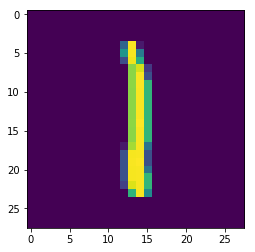

In [3]:
#plot of one image from our dataset to show mnist
plt.imshow(train_data[0].reshape(28,28))
print(train_labels[0])


In [4]:
# I tried a gaussian filter but its performance wasn't great. Left this in the code for replication purposes.
#Perhaps at this level of complication in a neural network it's best to let the features stay as is.
from scipy.ndimage import gaussian_filter
train_data_blur = []

for val in train_data.reshape(train_data.shape[0],28,28):
    train_data_blur.append(gaussian_filter(val, sigma = 1))
    
train_data_blur = np.array(train_data_blur).reshape(train_data.shape[0],28,28,1)
    
    


In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

x_train = train_data.reshape(train_data.shape[0],28,28,1)
y_train = train_labels
val_frac = 0.1
batch_size = 32

data_augmentor = ImageDataGenerator(featurewise_center=True, validation_split = val_frac)
data_augmentor.fit(x_train)

train_generator = data_augmentor.flow(x_train, to_categorical(y_train), batch_size=batch_size, subset="training", shuffle = False)
val_generator = data_augmentor.flow(x_train, to_categorical(y_train), batch_size=batch_size, subset="validation", shuffle = False)

In [6]:
def res_unit1(inp, a, b, block_id, layer_id, activation="elu"):
    
    Nonlinearity = lambda name: Activation(activation=tf.nn.elu, name=name)

    bn1 = BatchNorm(name=f"{block_id}/{layer_id}/bn1")(inp)
    elu1 = Nonlinearity(name=f"{block_id}/{layer_id}/{activation}1")(bn1)
    conv1 = Conv2D(filters=a, kernel_size=(1,1), name=f"{block_id}/{layer_id}/conv1")(elu1)

    bn2 = BatchNorm(name=f"{block_id}/{layer_id}/bn2")(conv1)
    elu2 = Nonlinearity(name=f"{block_id}/{layer_id}/{activation}2")(bn2)
    conv2 = Conv2D(filters=a, kernel_size=(3,3), padding="same", name=f"{block_id}/{layer_id}/conv2")(elu2)

    bn3 = BatchNorm(name=f"{block_id}/{layer_id}/bn3")(conv2)
    elu3 = Nonlinearity(name=f"{block_id}/{layer_id}/{activation}3")(bn3)
    conv3 = Conv2D(filters=b, kernel_size=(1,1), name=f"{block_id}/{layer_id}/conv3")(elu3)

    return Add(name=f"{block_id}/{layer_id}/add")([inp, conv3])

def res_unit2(inp, a, b, block_id, layer_id, activation="relu"):
    Nonlinearity = lambda name: Activation(activation=tf.nn.relu, name=name)

    bn = BatchNorm(name=f"{block_id}/{layer_id}/bn0")(inp)
    elu = Nonlinearity(name=f"{block_id}/{layer_id}/{activation}0")(bn)

    shortcut = Conv2D(filters=b, kernel_size=(1,1), strides=2, name=f"{block_id}/{layer_id}/shortcut-conv")(elu)

    conv0 = Conv2D(filters=a, kernel_size=(1,1), strides=2, name=f"{block_id}/{layer_id}/conv0")(elu)

    bn1 = BatchNorm(name=f"{block_id}/{layer_id}/bn1")(conv0)
    elu1 = Nonlinearity(name=f"{block_id}/{layer_id}/{activation}1")(bn1)
    conv1 = Conv2D(filters=a, kernel_size=(3,3), padding="same", name=f"{block_id}/{layer_id}/conv1")(elu1)

    bn2 = BatchNorm(name=f"{block_id}/{layer_id}/bn2")(conv1)
    elu2 = Nonlinearity(name=f"{block_id}/{layer_id}/{activation}2")(bn2)
    conv2 = Conv2D(filters=b, kernel_size=(1,1), name=f"{block_id}/{layer_id}/conv2")(elu2)

    return Add(name=f"{block_id}/{layer_id}/add")([shortcut, conv2])

In [7]:
def create_model(activation="elu"):
    img = Input(shape=(28,28,1), name="img")
    conv1 = Conv2D(filters=32, kernel_size=(7,7), name="0/0/conv")(img)
    elu1 = Activation(activation=activation, name=f"0/0/{activation}")(conv1)
    bn1 = BatchNorm(name="0/0/bn")(elu1)

    layer1_1 = res_unit1(bn1, 16, 32, 1, 1, activation=activation)
    layer1_2 = res_unit1(layer1_1, 16, 32, 1, 2, activation=activation)
    layer1_3 = res_unit1(layer1_2, 16, 32, 1, 3, activation=activation)

    layer2_1 = res_unit2(layer1_3, 32, 64, 2, 1, activation=activation)
    layer2_2 = res_unit1(layer2_1, 32, 64, 2, 2, activation=activation)
    layer2_3 = res_unit1(layer2_2, 32, 64, 2, 3, activation=activation)

    layer3_1 = res_unit2(layer2_3, 64, 128, 3, 1, activation=activation)
    layer3_2 = res_unit1(layer3_1, 64, 128, 3, 2, activation=activation)
    layer3_3 = res_unit1(layer3_2, 64, 128, 3, 3, activation=activation)

    layer4_1 = res_unit2(layer3_3, 128, 256, 4, 1, activation=activation)
    layer4_2 = res_unit1(layer4_1, 128, 256, 4, 2, activation=activation)
    layer4_3 = res_unit1(layer4_2, 128, 256, 4, 3, activation=activation)

    layer5_1 = res_unit2(layer4_3, 256, 512, 5, 1, activation=activation)
    layer5_2 = res_unit1(layer5_1, 256, 512, 5, 2, activation=activation)
    layer5_3 = res_unit1(layer5_2, 256, 512, 5, 3, activation=activation)

    average = GlobalMaxPool2D()(layer5_3)
    flatten = Flatten()(average)
    d = Dense(10, activation="softmax")(flatten) #changed to 10
    #out = Dense(10, activation='softmax')(d)
    
    return Model(inputs=[img], outputs=[d])

numpy.int64

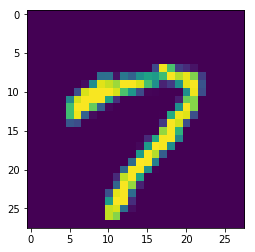

In [8]:
val = 10
plt.imshow(x_train.reshape(x_train.shape[0],28,28,1)[val].reshape(28,28))
to_categorical(y_train)[val]
type(y_train[val])

In [9]:
model = create_model("elu")
metrics = tf.keras.metrics
model.compile(
      loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(),
      metrics=[metrics.AUC(), metrics.Precision(), metrics.Recall(), metrics.CategoricalAccuracy(), ]
  )

#we see diminishing returns after the second epoch
history = model.fit_generator(train_generator, validation_data = val_generator, epochs=5)

Epoch 1/5
1154/1154 [==============================] - 95s 83ms/step - loss: 0.3091 - auc: 0.9896 - precision: 0.9380 - recall: 0.9202 - categorical_accuracy: 0.9264 - val_loss: 0.3586 - val_auc: 0.9885 - val_precision: 0.9004 - val_recall: 0.8756 - val_categorical_accuracy: 0.8898
Epoch 2/5
1154/1154 [==============================] - 75s 65ms/step - loss: 0.1443 - auc: 0.9961 - precision: 0.9684 - recall: 0.9598 - categorical_accuracy: 0.9636 - val_loss: 0.7596 - val_auc: 0.9719 - val_precision: 0.8946 - val_recall: 0.8885 - val_categorical_accuracy: 0.8917
Epoch 3/5
1154/1154 [==============================] - 75s 65ms/step - loss: 0.1078 - auc: 0.9973 - precision: 0.9756 - recall: 0.9695 - categorical_accuracy: 0.9720 - val_loss: 0.2157 - val_auc: 0.9927 - val_precision: 0.9643 - val_recall: 0.9617 - val_categorical_accuracy: 0.9627
Epoch 4/5
1154/1154 [==============================] - 76s 65ms/step - loss: 0.0628 - auc: 0.9987 - precision: 0.9853 - recall: 0.9814 - categorical_ac

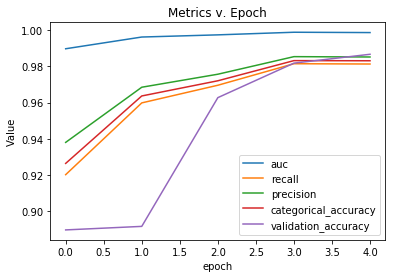

In [11]:
plt.plot(history.history['auc'])
plt.plot(history.history['recall'])
plt.plot(history.history['precision'])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Metrics v. Epoch')
plt.ylabel('Value')
plt.xlabel('epoch')
plt.legend(['auc', 'recall', 'precision','categorical_accuracy','validation_accuracy'], loc='lower right')
plt.show()


I don't recommend trying to run this model without some GPU hardware! I actually used some of the free 30 hours a week of P100 GPU access Kaggle provides to train my model!

## _Key Takeaways_

## Experiments
Even though I chose to use MNIST to train my data, I think this exercise was extremely valuable because it shows using the TF 2.0 and Keras framework in action, and turns an otherwise opaque ResNet 50 Model into something quite understandable! I played around with various techniques like smoothing, ZCA whitening, and gaussian blur and ultimately found centering the image was the most important technique for improved performance. I also found that while for the "normal" layers I would use an elu activation function (preserves negative weights), a ReLU function worked well for the residual blocks.

## Performance
To evaluate this model, I focused on the AUC, Precision and Recall, and Accuracy. When I was done fine-tuning the model, I added in validation accuracy for my data as to not bias my finetuning. For training, across various attempts at 5 epoch training, I found that training beyond 5 epochs resulted in overfitting and reduced performance on validation data.

Through finetuning my model on just ~30K values, I was able to achieve 99.8% AUC, 98.0% Precision, 97.5% Recall, and 98.5% Accuracy. This suggests the model was very good at distinguishing between various digits and did not face significant issues of False Positive, False Negative, True Positive, True Negative imbalance.

## Discussion
Compared to the standard ResNet model, I deploy the model with ReLU activation functions for residual blocks, ELU functions for standard blocks and ELU activation layers for higher up layers. I implemented this combination to counteract the 'dead neuron' problem of ReLU, where the gradient, once zero, cannot recover to a positive value, while empirically finding the blocks that needed to have a ReLU function. I think the balance between symmetric ReLUs and ELUs which are in some ways "curved" versions of a Leaky ReLU and have some negative weight possibility without scaling linearly (diminishing negative negative gradient) is useful for detecting what features do not correspond to certain digits. 

## Efficiency
Because of the scale of this model with 3 Million Nodes, it was important to focus on compute efficiency. This is why I used a data generator and trained on GPU via Kaggle's Kernel (it actually has a better GPU (P100) versus the Tesla K80s for Google Colab! 

Thanks for viewing this notebook!


